<a href="https://colab.research.google.com/github/walnashgit/ERAV2/blob/main/S7/model2/S7_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from gdrive.MyDrive.ERA.S7.model2.model_2 import Network

In [4]:
# Create simple transform and calculate mean and std dev.
simple_transforms = transforms.Compose([
    transforms.ToTensor()
])
exp = datasets.MNIST('./data', train = True, download = True, transform = simple_transforms)
exp_data = exp.transform(exp.data.numpy())

print("EXP")
print(' - Numpy Shape:', exp.data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))


EXP
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [5]:
#Prepare basic transforms using mean and std from above.
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

In [6]:
#Download data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

In [7]:
# Create data loader

SEED = 4

cuda = torch.cuda.is_available()
print("CUDA available: ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader args would be user input
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 2, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 128)

# Train loader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# Test loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA available:  True


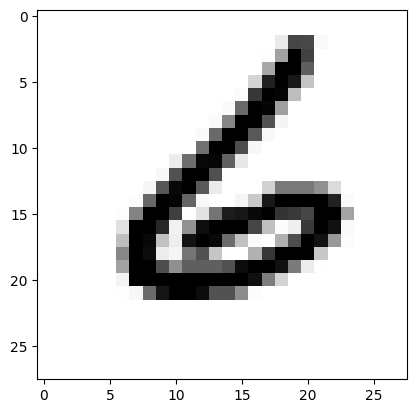

In [8]:
# Data visualization
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.imshow(images[0].squeeze(), cmap='gray_r')

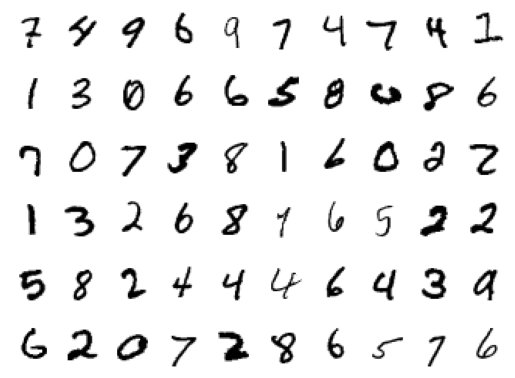

In [9]:
# check data to decide correct transforms needed.
# figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [10]:
# Model summary

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         Dropout2d-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           2,304
       BatchNorm2d-6           [-1, 16, 28, 28]              32
              ReLU-7           [-1, 16, 28, 28]               0
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 10, 14, 14]             160
      BatchNorm2d-11           [-1, 10, 14, 14]              20
             ReLU-12           [-1, 10, 14, 14]               0
        Dropout2d-13           [-1, 10, 14, 14]               0
           Conv2d-14           [-1

In [11]:
# Training and Testing code
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
# Running the model
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.38891324400901794 Batch_id=468 Accuracy=74.25: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]



Test set: Average loss: 0.1671, Accuracy: 9585/10000 (95.85%)

EPOCH: 1


Loss=0.1940198540687561 Batch_id=468 Accuracy=92.13: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.1085, Accuracy: 9695/10000 (96.95%)

EPOCH: 2


Loss=0.14213573932647705 Batch_id=468 Accuracy=94.19: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]



Test set: Average loss: 0.0795, Accuracy: 9775/10000 (97.75%)

EPOCH: 3


Loss=0.16222812235355377 Batch_id=468 Accuracy=95.11: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]



Test set: Average loss: 0.0754, Accuracy: 9775/10000 (97.75%)

EPOCH: 4


Loss=0.16811160743236542 Batch_id=468 Accuracy=95.63: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]



Test set: Average loss: 0.0633, Accuracy: 9820/10000 (98.20%)

EPOCH: 5


Loss=0.11353707313537598 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]



Test set: Average loss: 0.0603, Accuracy: 9828/10000 (98.28%)

EPOCH: 6


Loss=0.09859040379524231 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]



Test set: Average loss: 0.0518, Accuracy: 9850/10000 (98.50%)

EPOCH: 7


Loss=0.17416240274906158 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]



Test set: Average loss: 0.0510, Accuracy: 9836/10000 (98.36%)

EPOCH: 8


Loss=0.09900733083486557 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]



Test set: Average loss: 0.0445, Accuracy: 9860/10000 (98.60%)

EPOCH: 9


Loss=0.10999950021505356 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]



Test set: Average loss: 0.0447, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


Loss=0.052720408886671066 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]



Test set: Average loss: 0.0425, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.06595472246408463 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]



Test set: Average loss: 0.0403, Accuracy: 9871/10000 (98.71%)

EPOCH: 12


Loss=0.13999159634113312 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0417, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.17192548513412476 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]



Test set: Average loss: 0.0391, Accuracy: 9868/10000 (98.68%)

EPOCH: 14


Loss=0.02712278813123703 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]



Test set: Average loss: 0.0388, Accuracy: 9883/10000 (98.83%)

EPOCH: 15


Loss=0.1487923115491867 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0367, Accuracy: 9885/10000 (98.85%)

EPOCH: 16


Loss=0.06313268840312958 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0359, Accuracy: 9878/10000 (98.78%)

EPOCH: 17


Loss=0.059712741523981094 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]



Test set: Average loss: 0.0358, Accuracy: 9880/10000 (98.80%)

EPOCH: 18


Loss=0.022193195298314095 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0370, Accuracy: 9888/10000 (98.88%)

EPOCH: 19


Loss=0.01676361821591854 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]



Test set: Average loss: 0.0333, Accuracy: 9893/10000 (98.93%)



Text(0.5, 1.0, 'Test Accuracy')

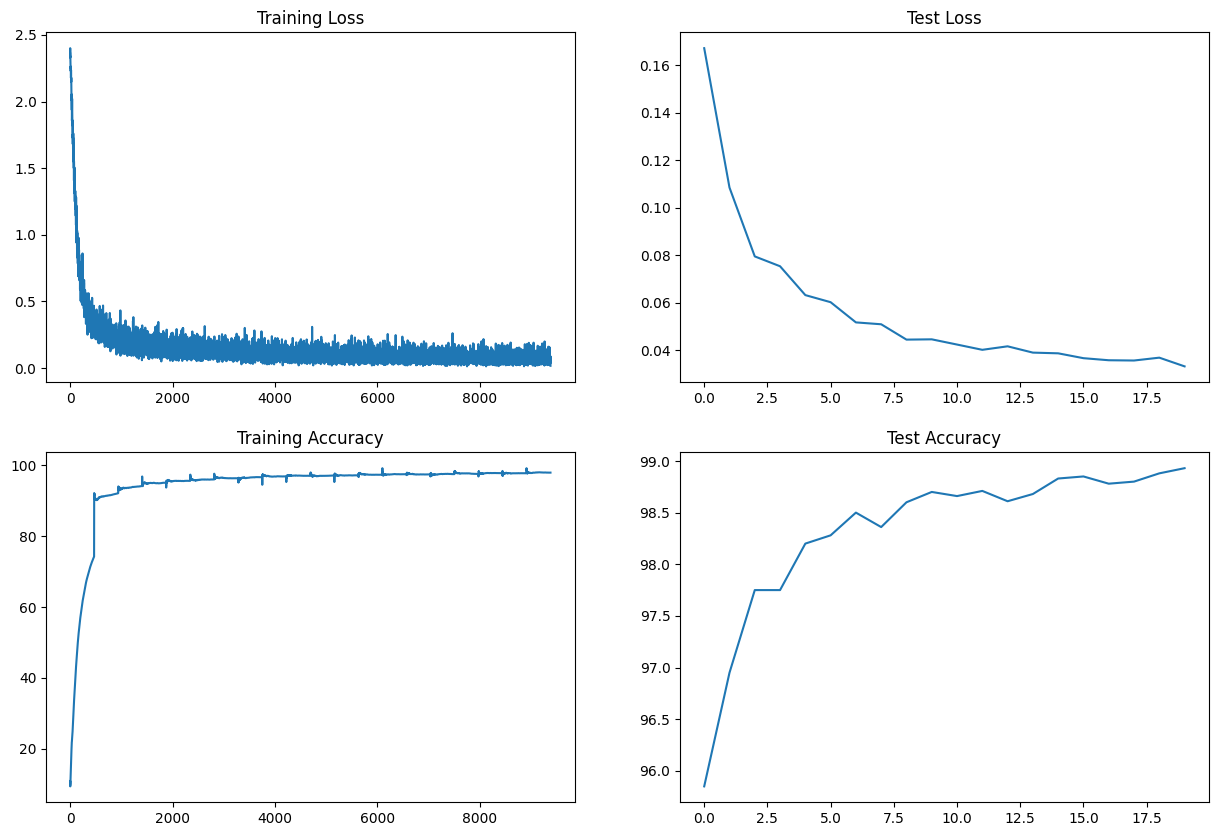

In [13]:
# Plot the training and test loss and accuracy
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Target:


1. Reduce overfitting by using diffrent architecture components like Batch Normalization, Dropout(Regularization) and Global Average Pooling.

# Result


1. Total params: 7,580
2. Best training accuracy: 97.97% (20th Epoch)
3. Best test accuracy: 98.93% (20th Epoch)



# Analysis



1. Model is lighter (7.5k Params). [Model](https://github.com/walnashgit/ERAV2/blob/main/S7/model2/model_2.py)
2. No overfitting is there.
3. Test and training accuracy is not very high but can increase if model is pushed further.
4. Increasing the capacity and placing some of the componenets like MaxPool at right location may help.
5. Making training a bit more difficult by adding image augmentation may also improve accuracy.





